# Sistema de Diagnóstico de Doenças com Redes Bayesianas

## Resumo

O sistema foi desenvolvido utilizando a biblioteca `pgmpy` e uma base de dados fictícia de diagnóstico de doenças a partir da análise clínica de sintomas e dados dos pacientes. A base contém diagnósticos para:

- Resfriado
- Gripe
- Bronquite
- Pneumonia
- Tuberculose

A partir das variáveis dependentes, foi construído um gráfico de depedência de forma manual, com base nas possíveis relações entre os sintomas e diagnóstico. Utilizando essas relações e os dados, foi construída as tabelas de probabilidade bayesiana para cada nó e em seguida, inferências de exemplo para visualização do funcionamento do sistema

![](src/diagnostico.png)

In [131]:
# Definição das bibliotecas python utilizadas
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BaseEstimator, PC
from pgmpy.inference import VariableElimination
import warnings
from IPython.display import Image

warnings.filterwarnings("ignore")

### Análise e Visualização dos Dados

In [126]:
df = pd.read_csv("src/sindromes_diagnostico.csv")
for col in df.columns:
    df[col] = df[col].astype('category')
df.head()

,faixa_etaria,fumante,tosse,febre,fadiga,falta_de_ar,dor_no_peito,dor_de_garganta,dor_de_cabeca,diagnostico
0,idoso,sim,persistente,alta,não,sim,intensa,sim,não,pneumonia
1,adulto,sim,não,não,sim,não,sim,não,não,tuberculose
2,adolescente,não,sim,sim,não,sim,sim,sim,não,resfriado
3,idoso,sim,sim,não,não,grave,intensa,não,não,tuberculose
4,criança,sim,sim,alta,sim,não,não,moderada,intensa,gripe


In [128]:
df.diagnostico.unique()

['pneumonia', 'tuberculose', 'resfriado', 'gripe', 'bronquite']
Categories (5, object): ['bronquite', 'gripe', 'pneumonia', 'resfriado', 'tuberculose']

In [127]:
list(df.columns)

['faixa_etaria',
 'fumante',
 'tosse',
 'febre',
 'fadiga',
 'falta_de_ar',
 'dor_no_peito',
 'dor_de_garganta',
 'dor_de_cabeca',
 'diagnostico']

### Definição do grafo

O grafo foi construído com base nas relações entre as variáveis, como a clara associação de tosse, e falta de ar a pessoas fumantes. Houve a tentativa de utilizar a própria biblioteca `pgmpy` para geração do grafo, mas as tentativas não geraram grafos muito coerentes

In [103]:
grafo = [
    ('fumante', 'tosse'),
    ('fumante', 'falta_de_ar'),
    ('tosse', 'falta_de_ar'),
    ('tosse', 'febre'),
    ('tosse', 'diagnostico'),
    ('febre', 'fadiga'),
    ('febre', 'diagnostico'),
    ('falta_de_ar', 'dor_no_peito'),
    ('falta_de_ar', 'diagnostico'),
    ('dor_no_peito', 'diagnostico'),
    ('dor_de_garganta', 'diagnostico'),
    ('dor_de_cabeca', 'diagnostico')
]

### Geração do Modelo

As tabelas para o modelo foram construida utilizando estimadores, mais especificamente, o **Maximum Likelihood Estimator**. Todas foram então adicionadas ao modelo construído em cima do grafo definido anteriormente

$$θ_{MLE} = \arg \max_{θ} L(θ∣D)$$

In [111]:
model = BayesianNetwork(grafo)
columns = ["fumante", "tosse", "febre", "fadiga", "falta_de_ar", "dor_no_peito", "dor_de_garganta", "dor_de_cabeca"]
model.add_cpds(*[MaximumLikelihoodEstimator(model, df).estimate_cpd(column) for column in columns])

model.add_cpds(MaximumLikelihoodEstimator(model, df).estimate_cpd("diagnostico"))

In [112]:
# Checagem da "saúde" do modelo
model.check_model()

True

### Visualização das Tabelas de Probabilidade

O `pgmpy` permite a visualização das tabelas de probabilidade bayesiana, seguindo um modo de visualização parecido com o do **Netica** (na edição dos nós)

In [124]:
cpds = model.get_cpds()
for cpd in cpds:
    print(cpd)

+--------------+------+
| fumante(não) | 0.46 |
+--------------+------+
| fumante(sim) | 0.54 |
+--------------+------+
+--------------------+---------------------+---------------------+
| fumante            | fumante(não)        | fumante(sim)        |
+--------------------+---------------------+---------------------+
| tosse(não)         | 0.3521739130434783  | 0.3333333333333333  |
+--------------------+---------------------+---------------------+
| tosse(persistente) | 0.3217391304347826  | 0.37407407407407406 |
+--------------------+---------------------+---------------------+
| tosse(sim)         | 0.32608695652173914 | 0.29259259259259257 |
+--------------------+---------------------+---------------------+
+-------------+---------------------+--------------------+---------------------+
| tosse       | tosse(não)          | tosse(persistente) | tosse(sim)          |
+-------------+---------------------+--------------------+---------------------+
| febre(alta) | 0.3391812865497076

### Exemplos do Sistema de Inferências

A escolha de função de inferência foi a de eliminação de variáveis, que consiste em, dado uma consulta $P(X|E)$, onde X é a variável de interesse e E as variáveis de evidência, realiza a multiplicação das tabelas de probabilidade relevantes pra consulta e elimina as variáveis não desejadas uma a uma através da soma das probabilidades

```python
infer = VariableEliminatio(model)
```

> O `pgmpy` conta com uma variedade de métodos de inferência e de construção das tabelas condições

In [136]:
infer = VariableElimination(model)

Devido a presença de sintomas comuns e genéricos, como tosse e dor de garganta, o modelo infere com proximidade um resultado entre gripe e resfriado, dando baixa probabilidade para doenças mais graves

In [137]:
# Fazendo uma inferência para diagnóstico
query_result = infer.query(variables=["diagnostico"], 
                           evidence={"tosse": "sim", "dor_de_garganta": "sim", "dor_de_cabeca": "não"})
print(query_result)

+--------------------------+--------------------+
| diagnostico              |   phi(diagnostico) |
+==========================+====================+
| diagnostico(bronquite)   |             0.0983 |
+--------------------------+--------------------+
| diagnostico(gripe)       |             0.2851 |
+--------------------------+--------------------+
| diagnostico(pneumonia)   |             0.1120 |
+--------------------------+--------------------+
| diagnostico(resfriado)   |             0.4063 |
+--------------------------+--------------------+
| diagnostico(tuberculose) |             0.0983 |
+--------------------------+--------------------+


Devido a sintomas como dor no peito intensa, tosse e o fato de ser fumante, é possível ver que o modelo infere com maior probabilidade a possibilidade de uma tuberculose

In [138]:
query_result = infer.query(variables=["diagnostico"], 
                           evidence={"tosse": "sim", "dor_de_garganta": "não", "dor_no_peito": "intensa", "fumante": "sim"})
print(query_result)

+--------------------------+--------------------+
| diagnostico              |   phi(diagnostico) |
+==========================+====================+
| diagnostico(bronquite)   |             0.1321 |
+--------------------------+--------------------+
| diagnostico(gripe)       |             0.0917 |
+--------------------------+--------------------+
| diagnostico(pneumonia)   |             0.2136 |
+--------------------------+--------------------+
| diagnostico(resfriado)   |             0.1169 |
+--------------------------+--------------------+
| diagnostico(tuberculose) |             0.4457 |
+--------------------------+--------------------+


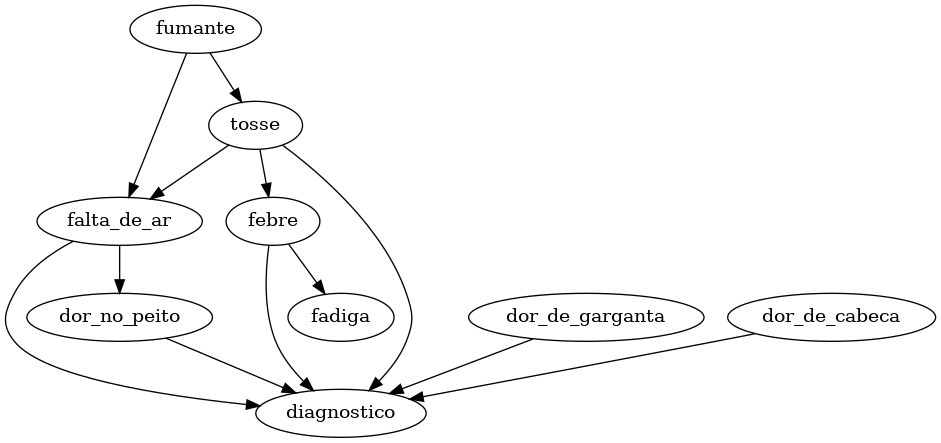

In [123]:
viz = model.to_graphviz()
viz.draw('diagnostico.png', prog='dot')
Image('diagnostico.png')